## Introduction

So far, you have developed Flopy models representing simplified geometries, such as a 1D laboratory column or a 2D sandbox. For many (most?) real-world applications, however, more detail is required. This notebook will demonstrate how to integrate GIS data into a Flopy structured grid geometry. In the x and y dimensions, a structured grid has a set cell size and thus a fixed number of rows and columns. In the z dimension, there are a fixed number of layers, but the layers may vary in thickness.  

The workflow usually looks like this:
1. Import libraries and define where MODFLOW executables and GIS data are located
2. Import and plot GIS data
3. Construct model grid and define layer elevations
4. Match the GIS data to grid cells  

Once the GIS data is matched to grid cells, you can pass the GIS data straight into your model.


Begin by importing the necessary packages

In [1]:

#use with environment "hydroclass"

import os
import time
from pathlib import Path

import flopy
from flopy.utils import GridIntersect, Raster
from flopy.utils.lgrutil import Lgr
from flopy.utils.postprocessing import get_water_table

import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from cmcrameri import cm


import earthpy.spatial as es
import rasterio
import rasterio.plot


# from shapely.geometry import Polygon, Point
# #import shapely.geometry
# import shapely.vectorized

# #from scipy import interpolate 
# from datetime import datetime, timedelta
# #possibly a package to read in rasters...

#ignoring annoying warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Arial']})
plt.rcParams['font.size'] = 16
plt.rcParams['lines.markersize']

c:\Users\jpsum\anaconda3\envs\hydroclass\Lib\site-packages\earthpy\__init__.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_string


6.0

Find where you have  MODFLOW 6 and MODPATH 7 located on your system (go back to the FloPy 1D Function MF6 notebook if you don't remember)

In [2]:
# Executable location of Mf6.exe
exe_path = Path(r"C:\WRDAPP\mf6.4.2_win64\bin\mf6.exe")
exe_loc = os.path.dirname(exe_path)

MP_path = Path(r"C:\WRDAPP\modpath_7_2_001\bin\mpath7.exe")
MP_loc = os.path.dirname(MP_path)
print("Path to MODFLOW 6 executable:", exe_loc)
print("Path to MODPATH 7 executable:", MP_loc)


Path to MODFLOW 6 executable: C:\WRDAPP\mf6.4.2_win64\bin
Path to MODPATH 7 executable: C:\WRDAPP\modpath_7_2_001\bin


Define path to model data

In [3]:
notebook_cwd = Path.cwd()
print("Notebook Directory:", notebook_cwd)
#project modeling folder and data folder
datapath = notebook_cwd / Path("GIS_Files") 
outdir = notebook_cwd / Path("Models") 
print(datapath)
print(outdir) 

Notebook Directory: c:\Users\jpsum\OneDrive - UW-Madison\CHydro\Guest Lecture\2-25-25 materials
c:\Users\jpsum\OneDrive - UW-Madison\CHydro\Guest Lecture\2-25-25 materials\GIS_Files
c:\Users\jpsum\OneDrive - UW-Madison\CHydro\Guest Lecture\2-25-25 materials\Models


In [4]:
#DEFINE GRIDBUILDER FUNCTION
def GRIDbuilder(model_domain_shp, cellsize, nlay, epsg, dem_file, 
                raster_interp_method, angle = 0, import_tops = False):
    '''
    Creates parent and child model grids and resamples DEM rasters to modelgrid
    
    Arguments

    *   model_domainshp (geopandas geometry): parent model boundaries
    
    *   cellsize (float): width and height of each model cell defined for the parent model
    
    *   nlay (int): number of layers for the parent model
    
    *   epsg (int -- ex 3071): coordinate reference system -- EPSG Geodetic Parameter Dataset
    
    *   raster_interp_method (string): chose from methods = "nearest", "linear" (bilinear), "cubic" (bicubic), "max", "min", "mean", "median", and "mode"

    
    Returns: 
    *   pgrid (array): parent model grid
    
    *   topp (array2d): raster DEM resampled to pgrid
    '''
    bounds_arr = model_domain_shp.bounds.to_numpy()
    xmin, ymin, xmax, ymax = bounds_arr[0][0], bounds_arr[0][1], bounds_arr[0][2], bounds_arr[0][3]
    
    domain_bounds = [xmin, ymin, xmax, ymax] 
    print(domain_bounds)
    
    dx = xmax - xmin
    dy = ymax - ymin

    nlay = nlay
    nrow = np.ceil(dy / cellsize).astype(int)
    ncol = np.ceil(dx / cellsize).astype(int)
    delr = np.full((ncol,), cellsize)
    delc = np.full((nrow,), cellsize)

    # let's create a fake top and bottom for now can be replaced!!! nice
    raster = Raster.load(dem_file)
    
    top = np.full((nrow, ncol), 1)
    botm = np.full((nlay, nrow, ncol), 0)
    
    pgrid = flopy.discretization.StructuredGrid(
        delc,
        delr,
        top=top,
        botm=botm,
        nlay=nlay,
        xoff=xmin,
        yoff=ymin,
        epsg=epsg,
        angrot=angle
    )
    #child domain = idomain
    #gx = GridIntersect(pgrid)
    
    # methods = "nearest", "linear" (bilinear), "cubic" (bicubic), "max", "min", "mean", "median", and "mode"
    if import_tops == True:
        topp = np.load(os.path.join(datapath, "topp{}.npy".format(int(cellsize))))
    else:
        print("resampling raster -- exporting to "+str(datapath))
        topp = raster.resample_to_grid(pgrid, band=raster.bands[0], method=raster_interp_method)
        np.save(os.path.join(datapath, "topp{}.npy".format(int(cellsize))), topp)
        
    print('Parent Model Grid created with resolution\n nlay: {}, nrow: {}, ncol: {}, delr: {}, delc: {}'.format(pgrid.nlay, pgrid.nrow, pgrid.ncol, pgrid.delr[0], pgrid.delc[0]))

    
    return pgrid, topp, 


# function to create hillshade image from DEM
def hillshade_gen(datapath, dem_filename, hillshade_filename):
    # Read the DEM data and metadata
    dem_file = os.path.join(datapath, dem_filename)
    raster_dem_dataset = rasterio.open(dem_file)
    dem_masked = raster_dem_dataset.read(1,masked=True)
    dem_metadata = raster_dem_dataset.meta.copy()
    
    # Create and plot the hillshade with earthpy
    hillshade_numpy = es.hillshade(dem_masked)
    
    # Create a new raster file for the hillshade
    hillshade_file = str(datapath) + '\\' + str(hillshade_filename)
    with rasterio.open(hillshade_file, 'w', **dem_metadata) as hillshade_dataset:
        hillshade_dataset.write(hillshade_numpy, 1)

#### 2: Import and plot GIS data

In [5]:
#Define Project EPSG
epsg = 6609


Look up the project EPSG on https://epsg.io. What units does it use?

In [6]:
# Load DEM and hillshade

dem_filename = "Final_Bathymetry.tif" 
# generate hillshade 
hillshade_filename = "French_Island_Hillshade.tif" #"French_island_hillshade.tif"

# if hillshade doesn't exist then generate
file_path = os.path.join(datapath, hillshade_filename)
if os.path.exists(file_path) == False:
    hillshade_gen(datapath, dem_filename, hillshade_filename)
    
hillshade_file = os.path.join(datapath, hillshade_filename)
hillshade_dataset = rasterio.open(hillshade_file)
hillshade_masked = hillshade_dataset.read(1,masked=True)


dem_file = os.path.join(datapath, dem_filename)


dem_dataset = rasterio.open(dem_file)

#Check to see if the DEM is in the correct CRS
print("DEM CRS:", dem_dataset.meta["crs"])
if int(str(dem_dataset.meta["crs"])[-4:]) == epsg:
    print("all Good")
else:
    print("Error: transfomration needed. DEM crs epsg: %d is not  progect CRS epsg: %d" %(int(str(dem_dataset.meta["crs"])[-4:]), epsg))

dem_masked = dem_dataset.read(1,masked=True)


DEM CRS: EPSG:6609
all Good


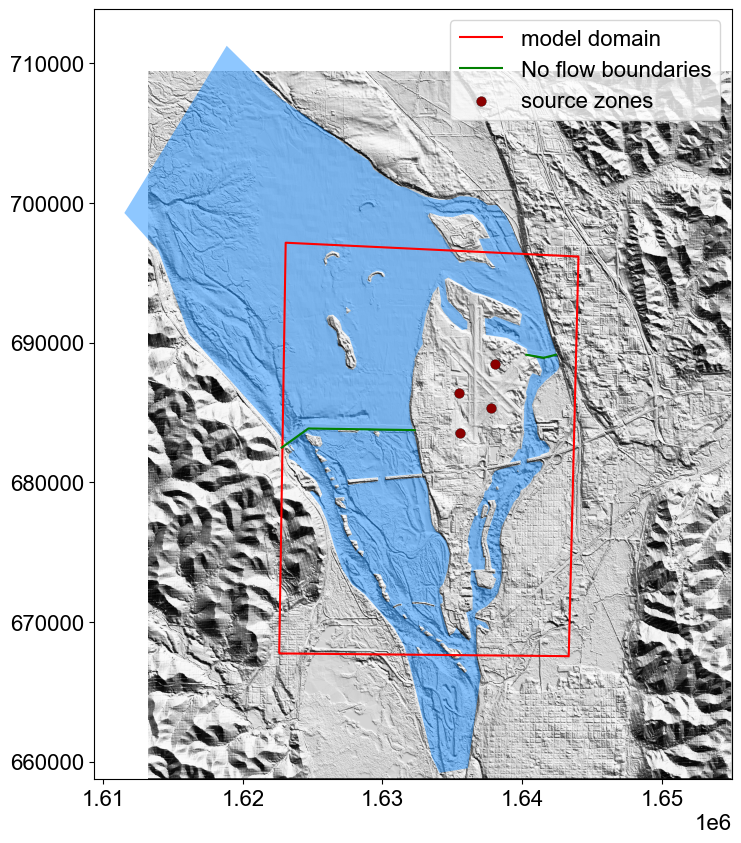

In [7]:
#Pull in helful shapefiles

#Shapefile to define model domain (extent)
farfield = gpd.read_file(os.path.join(datapath,'Farfield2.shp'))

#model boundary conditions
noflow = gpd.read_file(os.path.join(datapath,'LockDam_lines.shp'))
pools = gpd.read_file(os.path.join(datapath, "pools.shp"))

#datasets
src_zones = gpd.read_file(os.path.join(datapath, "source_zones.shp"))

# #convert to project coordinate system
farfield.to_crs(epsg=epsg, inplace=True)
noflow.to_crs(epsg=epsg, inplace=True)
pools.to_crs(epsg=epsg, inplace=True)

#Try commenting out this line to see what happens to the plot
src_zones.to_crs(epsg=epsg, inplace=True)

#visualize GIS data
fig, ax = plt.subplots(figsize = (10,10))
    #Plot DEM using rasterio
rasterio.plot.show(hillshade_masked, transform=hillshade_dataset.transform, ax=ax, cmap = "Greys_r")

    # Add vector data to a plot using methods of the GeoDataFrame (Geopandas variable class)
farfield.boundary.plot(ax=ax,color='red', label = "model domain")
pools.plot(ax=ax,color='dodgerblue', alpha=0.5, label = "Pools")
noflow.plot(ax=ax,color='green', label = "No flow boundaries")
src_zones.plot(ax=ax, color = "darkred", edgecolor = 'k', markersize = 50, lw = 0.2, label = "source zones")
plt.legend()


#### 3: Construct Grid 

In [8]:

# mgrids is a list of [flopy grid, resampled DEM]
mgrids = GRIDbuilder(model_domain_shp = farfield,
                    cellsize = 100, #EPSG horizontal units. For EPSG 6609, should be in USft
                    nlay = 7, 
                    epsg = epsg, 
                    dem_file = dem_file, 
                    raster_interp_method = "nearest",
                    angle = 0)



[1622609.5768064873, 667544.2884216845, 1644033.6818665352, 697144.6776871564]
resampling raster -- exporting to c:\Users\jpsum\OneDrive - UW-Madison\CHydro\Guest Lecture\2-25-25 materials\GIS_Files
Parent Model Grid created with resolution
 nlay: 7, nrow: 297, ncol: 215, delr: 100.0, delc: 100.0


In [9]:
#Find the number of rows and columns
gridNrow, gridNcol = mgrids[1].shape
print(gridNrow, gridNcol)

297 215


#### 4: Define Layers and surfaces:

We specified 7 layers for the model grid. Here, we generate them. Remember that the goal is to produce a numpy array with the same number of rows and columns as the FloPy grid. Each entry of the array corresponds to the base elevation of the layer at each cell.  

An example is given below. It takes a nrow by ncol matrix of ones and multiplies it by an elevation value. This would give you a perfectly flat layer base set to the specified elevation.

In [10]:
elev_example = 200

layer_base_example = np.ones((gridNrow, gridNcol)) * elev_example

For this model, we need a bit more. The functions defined in the next cell probably look like a mess. But the input/output of each one is straightforward:
*   plane_from_sdel takes a strike and dip measurement; the elevation of a of rock layer at a given cell location (maybe from a well survey); and the desired shape of the final 2D array. The plane defined by the strike and dip is extrapolated over the whole model domain and output into the correct dimension 2D array. 
*   Divide_layers is used to divide a layer into more layers. It inputs the top and bottom surfaces of each layers and divides it into c number of evenly spaced layers. It returns a list of the new surface arrays.

In [11]:
def plane_from_sdel(strike, dip, elevation, reference_cell, nrow, ncol):
    dip_az = strike + 90
    strike = np.array([np.sin(np.deg2rad(strike)), np.cos(np.deg2rad(strike))])
    dip_azimuth = np.array([np.sin(np.deg2rad(dip_az)), np.cos(np.deg2rad(dip_az))])
    #origin = np.array([reference_cell[0], reference_cell[1]])

    elevs = np.zeros((nrow, ncol))
    for i in range(elevs.shape[0]):  # Loop over rows
        for j in range(elevs.shape[1]):  # Loop over columns
            if reference_cell[0] == i and reference_cell[1] == j:
                elevs[i, j] = elevation
            else: 
                delta_x =  reference_cell[0] - i
                delta_y =  reference_cell[1] - j
                #print(origin)
                r = np.array([delta_x, delta_x])
                #print(r)
                norm_r = np.sqrt(delta_x**2 + delta_y**2)
                theta = np.arccos(np.dot(r, strike)/(norm_r*np.linalg.norm(strike)))
                if np.dot(dip_azimuth, r) >= 0:
                    deltaH = norm_r * np.tan(np.deg2rad(dip)) * np.sin(theta)
                else: 
                    deltaH = -1 * norm_r * np.tan(np.deg2rad(dip)) * np.sin(theta)

                elevs[i, j] = elevation - deltaH
    
    return elevs

def divide_layers(top_surface, bottom_surface, c):
    # Ensure c is a positive integer greater than 1
    if not isinstance(c, int) or c < 2:
        raise ValueError("c must be a positive integer greater than 1")
    if top_surface.shape != bottom_surface.shape:
        raise ValueError("Dimensions of top and bottom arrays must match")

    # Create a list to hold the interpolated surfaces
    surfaces = []
    # Calculate the interpolation weight
    #wt = [L/c for L in range(1, c)]
    
    # Iterate over the layers
    for L in range(c-1, 0, -1):
        surface_L = np.zeros(top_surface.shape)
        for i in range(top_surface.shape[0]):  # Loop over rows
            for j in range(top_surface.shape[1]):  # Loop over columns
                Delta_el = top_surface[i, j] - bottom_surface[i, j]
                surface_L[i, j] = ((L/c)*Delta_el) + bottom_surface[i, j]
        surfaces.append(surface_L)
    return surfaces



In [12]:
bom_layer_0 = plane_from_sdel(135, 0.10851, 500, [gridNrow//2, gridNcol//2], gridNrow, gridNcol)
surfaces = divide_layers(mgrids[1], bom_layer_0,  4)
layer_bases = surfaces + [bom_layer_0, bom_layer_0 - (15), bom_layer_0 - (50), bom_layer_0 - (115)]

#print the average elevation of each layer
for i in range(len(layer_bases)):
    print("%d: %0.1f ft" %(i, np.mean(layer_bases[i])))

0: 613.8 ft
1: 575.9 ft
2: 537.9 ft
3: 500.0 ft
4: 485.0 ft
5: 450.0 ft
6: 385.0 ft


#### 4: Match the GIS data to grid cells

In [13]:
#Print Contant head conditions for pool 7 and pool 8
Pool7CH = (639. - 1.03)
Pool8CH = (633. - 1.78)

print(Pool7CH, Pool8CH)

637.97 631.22


Now we start intersecting the shapefiles with the grid. We can't do this directly, so we first use provided class GridIntersect 

In [14]:
#boundary intersections
#mgrids is a tuple of the following: pgrid, topp, 
gx = GridIntersect(mgrids[0])

Now we can use gx to intersect shapefiles

In [15]:

#Model domain
idomain_intersect = gx.intersect(farfield.geometry[0], min_area_fraction=0.5, return_all_intersections=False)
ibound = list(idomain_intersect.cellids)


In [16]:
#The pools shapefile has two features: [0] is pool 7 and [1] is pool 8

# find location of cells that fall within pool 7 shape
pool7_intersect = gx.intersect(pools.geometry[0], min_area_fraction=0.5, return_all_intersections=False)
# these numpy recarrays have dtypes of ('cellids', 'vertices', 'areas', 'ixshapes')
pool7_cells = list(pool7_intersect.cellids)
# Print a few cellids (layer, row, column, for a regular grid). There are two values because??
print(pool7_cells[:5])


[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]


In [17]:
pool8_intersect = gx.intersect(pools.geometry[1], min_area_fraction=0.5, return_all_intersections=False)
pool8_cells = list(pool8_intersect.cellids)

In [18]:
'''This is another function made out of necessity. The model crashes if the base elvation of a constant head cell is higher than 
the assigned head value, so this just filters those cells out
'''

def remove_dry_pool_cells(poolcells: list, layerBase: np.array, head: float, tolerance: float = 0.00001):
    '''Assumes if the minimum cell elevation of the first layer is greater than the head that will be specified for that cell,
    then the cell must be dry land and the shapefile was overextended.

    poolcells: list
        * The list of cells to be filtered
    layerBase: numpy array
        * A numpy array of the base elevations for the first layer.
    head: float
        * The constant head for the pool
    tolerance: float
        * A small number that deactivates the cell if the sum of it and the minimum cell elevation is greater than the specified head
          This prevents any problems if the minimum cell elevation equals the head'''
    
    filteredCells = []
    for i in poolcells:
        j,k = i
        if layerBase[0][j][k] < head + tolerance:
            filteredCells.append(i)
    return filteredCells



pool7_cells_filtered= remove_dry_pool_cells(pool7_cells, layer_bases, Pool7CH)
pool8_cells_filtered = remove_dry_pool_cells(pool8_cells, layer_bases, Pool8CH)

pool_datasets = [pool7_cells_filtered, pool8_cells_filtered]


In [19]:
#Iterate through all the noflow features (e.g., the dams on either side of the island) and intersect them with the grid
noflow_bd = []
for iloc, row in noflow.iterrows():
    results = gx.intersect(row.geometry, min_area_fraction=None, return_all_intersections=True)
    # get cellids of no flow cells
    noflow_bd += list(results.cellids)


In [20]:
# Extract Cell IDs of Source zones
source_cells = np.zeros((len(src_zones), 2), dtype=int)
for i, (iloc, row) in enumerate(src_zones.iterrows()):
    # parent mesh 
    results = gx.intersect(row.geometry, contains_centroid=True)
    # as np array
    source_cells[i, :] = np.array(results.cellids[0], dtype=int)
source_cells = np.insert(source_cells, 000, 0, axis = 1)
print(source_cells)


[[  0  87 154]
 [  0 108 128]
 [  0 119 151]
 [  0 137 129]]


Let's check to make sure everything worked correctly. We should get a plot showing the model domain, a distinct pool 7 and pool 8, and the noflow dam lines. Everywhere else should just be the DEM

mean river statge in Pool 7 (upstream): 632.96 feet
mean river statge in Pool 8 (downstream): 626.43 feet


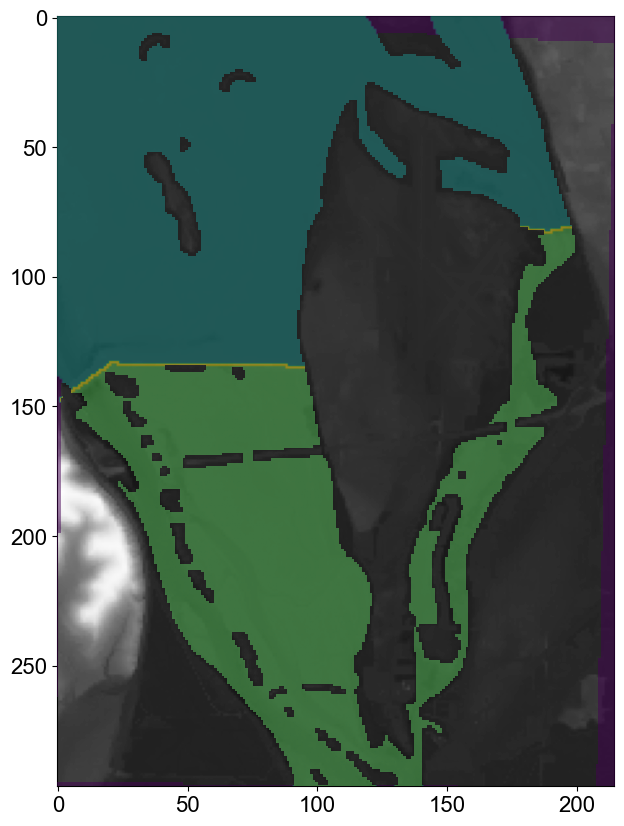

In [21]:
#Boundary Condition Visualization
# top boundary sampled from DEM on parent grid
topp = mgrids[1]

#Initialize an array of grid shape
bounds = np.zeros(topp.shape)

# The zip function unpacks a list of n-dimensional tuples into n lists of numbers
# So here, it takes the (x,y) in each cell list and produces a list of x's and of y's
j_bd, i_bd = zip(*ibound)
j_nf, i_nf = zip(*noflow_bd)
j_p7, i_p7 = zip(*pool7_cells_filtered)
j_p8, i_p8 = zip(*pool8_cells_filtered)


#Now we assign each cell in the bounds array to their proper boundary condition
#Main domain
bounds[j_bd, i_bd] = 1

#Pool Cells
bounds[j_p7, i_p7] = 2
bounds[j_p8, i_p8] = 3

#no flow
bounds[j_nf, i_nf] = 4

#finally, we will mask (hide) every cell in the domain that is not a boundary condition
bounds_mask = np.ma.masked_where(bounds == 1, bounds)

#Print the average river stages
mean_stg_p7 = np.where(bounds == 2, topp, np.nan)
print("mean river statge in Pool 7 (upstream): %0.2f feet" %np.nanmean(mean_stg_p7))
mean_stg_p8 = np.where(bounds == 3, topp, np.nan)
print("mean river statge in Pool 8 (downstream): %0.2f feet" %np.nanmean(mean_stg_p8))

#Plot an overview figure
fig = plt.figure(figsize=(10,10))
plt.imshow(topp, cmap = "Greys_r")
plt.imshow(bounds_mask, zorder = 10, alpha=0.5)
plt.show()



In [22]:
#NWT simplified model.
#https://modflow6-examples.readthedocs.io/en/master/_examples/ex-gwf-nwt-p03.html
def NWT_Mf6(sim_name, pgrid, topp, pools, bottomLayers, recharge, hk1,  #general steady-state model inputs   
            upperPoolStage = (639.-1.03),
            lowerPoolStage = (633.-1.78),
            rfac = None,                                                                                                                                                                   porosity = 0.3, bulk_density=50.9703*12/39.37,  distcoef=0.0,                                               
            particle_tracking = None, particle_loc = None, zonedataoption="off", termination_zones = None,                                                                                                                                                                      #PEST optimization recharge factor  
           ): 
    
    #define directies
    ws_dir = outdir
    directory = sim_name
    #Check to see if directory already exists.
    #If not, make new directory

    if os.path.exists(os.path.join(ws_dir, directory)):
        files = os.path.join(ws_dir, directory)
        for file in files:
            file_path = os.path.join(os.path.join(ws_dir, directory), file)
            if os.path.isfile(file_path):
                os.remove(file_path)
    if not os.path.exists(os.path.join(ws_dir, directory)):
        os.mkdir(os.path.join(ws_dir, directory))
    model_dir = os.path.join(ws_dir, directory)

    print("building groundwater simulation--output location: {}".format(model_dir))
    
    # create the MF6 simulation
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, exe_name=os.path.join(exe_loc, 'mf6.exe'), sim_ws=model_dir)

    # create tdis package #units will be in feet and days
    
    perlen = [1] #steady tstate
    nstp = [1] #[10]
    tsmult = [1.0]
    tdis_rc = list(zip(perlen, nstp, tsmult))
    days_spd = tdis_rc
    nper = len(perlen)
    

    tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', nper = nper, perioddata = tdis_rc)
    print(tdis)
    
    #initialize the flow model
    model_name = 'parent'
    gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, model_nam_file='{}.nam'.format(model_name), 
                               save_flows=True)#, newtonoptions = "newton under_relaxation")
    
    #ims package
    imsgwf = flopy.mf6.ModflowIms(sim, print_option="SUMMARY",
             filename=f"{model_name}.ims")

    sim.register_ims_package(imsgwf, [gwf.name])

    
    #dis package
    nlay, nrow, ncol, delr, delc = pgrid.nlay, pgrid.nrow, pgrid.ncol, pgrid.delr, pgrid.delc
    
    print("The number of Layers is %d" %nlay)
   
    
    botmp = bottomLayers
    botmp = np.asarray(botmp)
    print("len bottom array = %d" %len(botmp))
    
    idomain = np.zeros([nlay, nrow, ncol])
    
    for k in range(nlay):
        for (i, j) in ibound:
            idomain[k, i, j] = 1   

    for (i, j) in noflow_bd:
        idomain[0, i, j] = 0  
    
    disf = flopy.mf6.ModflowGwfdis(
        gwf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=topp,
        botm=botmp,
        idomain=idomain, 
        xorigin = pgrid.extent[0],
        yorigin = pgrid.extent[2] 
    )
    
    #IC package
    strt_head = np.mean([upperPoolStage, lowerPoolStage]) #*12/39.37 #m
    strt = np.ones([pgrid.nlay, pgrid.nrow, pgrid.ncol])*strt_head
    ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=strt)
    
    #chd - Pools 7 and 8
    cspd = [] #rec arrays
    for (i, j) in pools[0]: #pool 7 upstream
        if idomain[0, i, j] == 1:
            cspd.append(((0, i, j), upperPoolStage)) #get the mean stage between all model runs

    for (i, j) in pools[1]: #pool 8 downstream
        if idomain[0, i, j] == 1:
            cspd.append(((0, i, j), lowerPoolStage))
    
    cspd_uniques = set(cspd) #find and remove and duplicate geometry      
    cspd_perdata = {0: list(cspd_uniques)}#, 1: list(cspd_uniques)}

    

    chd = flopy.mf6.ModflowGwfchd(gwf, save_flows=True, maxbound=len(cspd_perdata[0]), stress_period_data = cspd_perdata, pname = '.chd')
    
    #NPF package========================================================================================================================      
    npf = flopy.mf6.ModflowGwfnpf(gwf, k33overk=True, icelltype=[1], k = hk1, k33 = 0.1)
    
    #recharge -- to be calibrated with PEST++================================================================================================
    if rfac is not None:
        recharge = recharge*rfac
        
    rcha = np.ones((nrow, ncol))*recharge
    rch = flopy.mf6.ModflowGwfrcha(gwf, readasarrays=True, recharge=rcha) #ft/day
      
    #Output control for the parent model
    oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='parent.cbc', budgetcsv_filerecord = 'parent_budget.csv',
                                head_filerecord='parent.hds',
                                headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 4, 'GENERAL')],
                                saverecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')], #ALL
                                printrecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')])
      
       
    return sim, days_spd


In [ ]:
#model without transport
run="nt"
sim_name = "run" + str(run).zfill(3)
sim, perdata = NWT_Mf6(sim_name= sim_name, 
                  pgrid = mgrids[0], 
                  topp = topp, 
                  pools = [pool7_cells, pool8_cells], 
                  bottomLayers = layer_bases,
                  upperPoolStage = 637.93,
                  lowerPoolStage = 631.21,
                  recharge = 12.01/12/365, #ft/day 
                  hk1 = [1470, 1470, 1470, 1470, 5, 10, 10],
                  )

sim.write_simulation(silent=True)
sim.run_simulation(silent=False)


building groundwater simulation--output location: c:\Users\jpsum\OneDrive - UW-Madison\CHydro\Guest Lecture\2-25-25 materials\Models\run0nt
package_name = tdis
filename = run0nt.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = run0nt

Block options
--------------------
time_units
{internal}
(days)


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
([(1., 1, 1.)])



The number of Layers is 7
len bottom array = 7
FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\..\WRDAPP\mf6.4.2_win64\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:41:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_0

(True, [])

In [24]:
t2 = time.time()
#print("The total time to run notebook to here is %0.3f seconds"%(t2 - t0))
model_names = list(sim.model_names)
print(model_names)

#get the models as outputs
gwf = sim.get_model(model_names[0]) #groundwater flow model

#
head = gwf.output.head().get_alldata()
heads = np.ma.masked_where(head < 1e29, head)

#get the water table
wtr_tbl = get_water_table(head)



['parent']


1622609.5768064873 1644109.5768064873 667544.2884216845 697244.2884216845


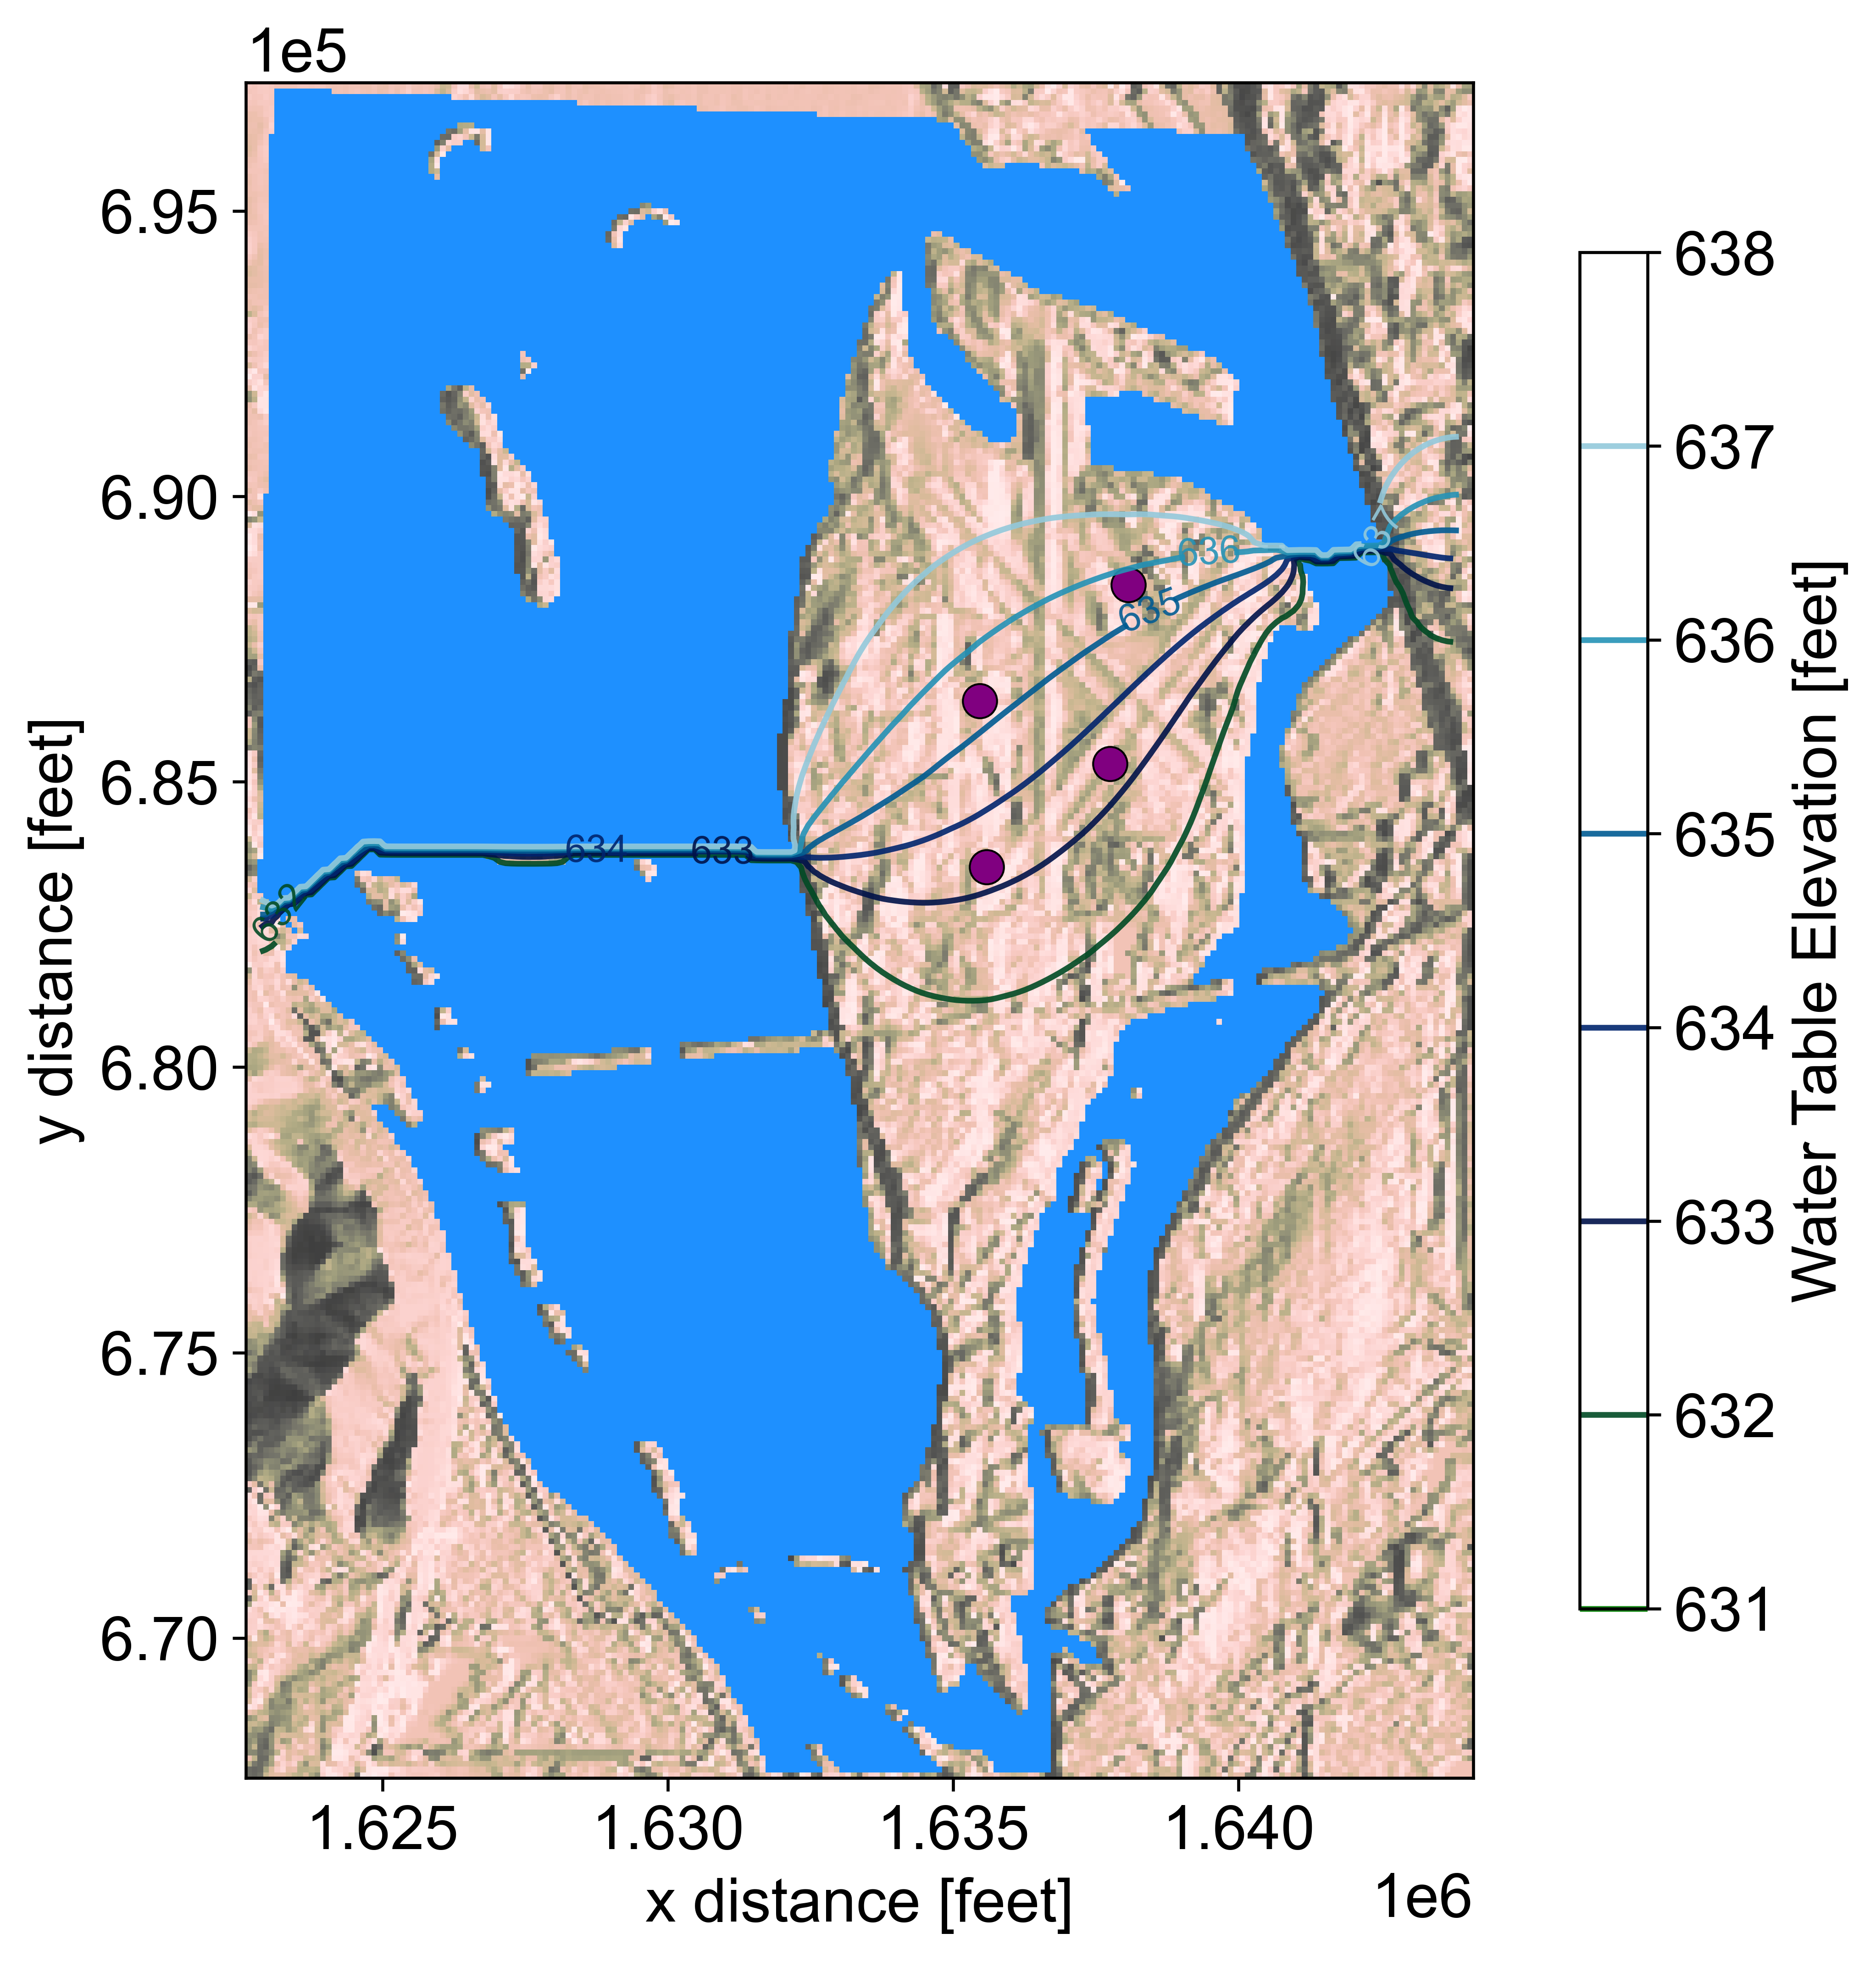

In [25]:

#water table plot
time_stp = 10
fig, ax = plt.subplots(1,1, figsize = (10, 8), dpi = 600)


xmin, xmax, ymin, ymax = gwf.modelgrid.extent ##
#ximin, ximax, yimin, yimax = 1635385.72, 1637348.29, 679743.74, 683716.47
print(xmin,xmax, ymin, ymax)
buff = 1000
pmv = flopy.plot.PlotMapView(model=gwf, ax = ax, layer = 0)
ls = LightSource(azdeg=100, altdeg=40)

pmv.plot_array(ls.hillshade(topp, vert_exag = 0.5), cmap = cm.turku, alpha = 0.5)

pmv_ts = pmv.contour_array(wtr_tbl, masked_values=[1e30], cmap = "ocean",  alpha = 0.9) 
plt.colorbar(pmv_ts, label = "Water Table Elevation [feet]", shrink = 0.8)
ax.clabel(pmv_ts, inline=True, fontsize=10)
pmv.plot_bc("CHD", color = "dodgerblue")

ax.set_xlabel("x distance [feet]")
ax.set_ylabel("y distance [feet]")
ax.ticklabel_format(axis="both", scilimits = [-3, 3])

source_plot = src_zones.plot(ax=ax, color = "purple",  edgecolor = 'k', markersize = 80, lw = 0.5)


